In [5]:
import numpy as np
import cv2
from pylab import *
import random

def sift(img1, img2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    correspondences = np.zeros((2, len(good_matches), 2))

    for i, match in enumerate(good_matches):
        correspondences[0, i, :] = np.flip(kp1[match.queryIdx].pt)
        correspondences[1, i, :] = np.flip(kp2[match.trainIdx].pt)

    return correspondences



In [6]:
def floor(value):
    if value >= 0:
        return int(value)
    else:
        return int(value)-1
def bilinear(source_image, x, y):
    end_x, end_y = np.shape(source_image)
    x_f, y_f = floor(x), floor(y)
    a = x-x_f
    b = y-y_f
    if (x_f >= 0 and x_f < end_x-1 )and (y_f >= 0 and y_f < end_y-1):
        i_v = (1-a)*(1-b)*source_image[x_f, y_f] \
            + (1-a)*b*source_image[x_f, y_f+1] \
            + a*(1-b)*source_image[x_f+1, y_f] \
            + a*b*source_image[x_f+1, y_f+1]
    else:
        i_v = 0
    return i_v

In [7]:
def _2D(H, x):
    x_ = np.dot(H,x)
    if x_[-1]!=0:
        return x_[0]/x_[-1], x_[1]/x_[-1]
    else:
        return 0, 0
def transform_image(source_image, H, rows, cols ):

    H_inv = np.linalg.inv(H)

    target_image = np.zeros((rows, cols))

    for xt in range(rows):
        for yt in range(cols):
            vec = np.array([xt, yt-cenx, 1])
            xs, ys = _2D(H_inv, vec)
            val = bilinear(source_image, xs, ys)
            target_image[xt, yt] = val
    return target_image

In [8]:
def compute_homography(src, dst):
    A = []
    for i in range(4):
        x, y = src[i]
        u, v = dst[i]
        A.append([-x, -y, -1, 0, 0, 0, u*x, u*y, u])
        A.append([0, 0, 0, -x, -y, -1, v*x, v*y, v])
    A = np.array(A)
    U, S, Vh = np.linalg.svd(A)
    L = Vh[-1,:] / Vh[-1,-1]
    H = L.reshape(3, 3)

    return H


In [9]:
def ransac_homography(points1, points2, num_iterations, inlier_threshold):
    points1 = np.array(points1)
    points2 = np.array(points2)
    best_homography = None
    best_inliers = []
    for i in range(num_iterations):
        indices = random.sample(range(len(points1)), 4)
        src = points1[indices]
        dst = points2[indices]
        H = compute_homography(src, dst)
        transformed_points = np.dot(H, np.vstack([points1.T, np.ones(len(points1))]))
        transformed_points = transformed_points[:2] / transformed_points[2]
        distances = norm(transformed_points - points2.T, axis=0)
        inliers = np.where(distances < inlier_threshold)[0]
        if len(inliers) > len(best_inliers):
            best_homography = H
            best_inliers = inliers
    return best_homography, best_inliers

In [10]:
src1=cv2.imread('im1.png',0)
src2=cv2.imread('im2.png',0)
src3=cv2.imread('im3.png',0)
[correspa1, correspa2] = sift(src1,src2)
[correspc1, correspc2] = sift(src3,src2)
H1,in1 = ransac_homography(correspa1,correspa2,256,10)
H3,inl2 = ransac_homography(correspc1,correspc2,256,10)
cenx = int(floor(shape(src1)[1]))
nrows = shape(src2)[0]
ncolumns = shape(src1)[1] + shape(src2)[1] + shape(src3)[1]
canvas = np.zeros((nrows,ncolumns))
count = np.zeros((nrows,ncolumns))
canvas1 = transform_image(src1, H1, nrows, ncolumns)
canvas2 = transform_image(src2, np.identity(3), nrows, ncolumns)
canvas3 = transform_image(src3, H3, nrows, ncolumns)
num = np.equal(canvas1,np.zeros(shape(canvas1)))
num = ~num
num = num.astype(int)
count= count + num
num = np.equal(canvas2,np.zeros(shape(canvas2)))
num = ~num
num = num.astype(int)
count = count+ num
num = np.equal(canvas3,np.zeros(shape(canvas3)))
num = ~num
num = num.astype(int)
count = count + num
canvas = canvas1 + canvas3 + canvas2
count[count == 0] =  1


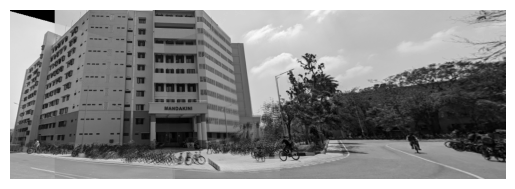

In [11]:
final_canvas=np.divide(canvas, count)
final_canvas=final_canvas[:, 385:1720]
#final_canvas=final_canvas[:, 550:]
plt.imshow(final_canvas,cmap = "gray")
plt.axis("off")
plt.show()